# 7 Moving Beyond Linearity

## 7.5 Smoothing Splines

### 7.5.1 An Overview of Smoothing Splines

  In the last section we discussed regression splines, which we create by specifying a set of knots, producing a sequence of basis functions, and then using least squares to estimate the spline coefficients. We now introduce a
somewhat different approach that also produces a spline.

  In fitting a smooth curve to a set of data, what we really want to do is
find some function, say g(x), that fits the observed data well: that is, we
want$RSS={\sum_{i=1}^{n}{(y_i-g(x_i))^2}}$to be small. However, there is a problem
with this approach. If we don’t put any constraints on$g(x_i)$,then we can
always make RSS zero simply by choosing g such that it interpolates all of
the$y_i$,Such a function would woefully overfit the data — it would be far
too flexible. What we really want is a function g that makes RSS small,
but that is also smooth.

  How might we ensure that g is smooth? There are a number of ways to
do this. A natural approach is to find the function g that minimizes
$$
\begin{align}
 {\sum_{i=1}^{n}{(y_i-g(x_i))^2}}+\lambda \int g''(t)^2 \,{\rm d}t\tag{7.11},\\
\end{align}
$$
where λ is a nonnegative tuning parameter. The function g that minimizes
(7.11) is known as a smoothing spline.

What does (7.11) mean? Equation 7.11 takes the “Loss+Penalty” formulation that we encounter in the context of ridge regression and the lasso in
Chapter 6. The term ${\sum_{i=1}^{n}{(y_i-g(x_i))^2}}$
is a loss function that encourages g to fit the data well, and the term$\lambda \int g''(t)^2 \,{\rm d}t$ is a penalty term that penalizes the variability in g. The notation g
′′(t) indicates the second derivative
of the function g. The first derivative g
′
(t) measures the slope of a function
at t, and the second derivative corresponds to the amount by which the
slope is changing. Hence, broadly speaking, the second derivative of a function is a measure of its roughness: it is large in absolute value if g(t) is very
wiggly near t, and it is close to zero otherwise.

Figure 7.8 shows the results from fitting a smoothing spline to the Wage
data. The red curve indicates the fit obtained from pre-specifying that we
would like a smoothing spline with 16 effective degrees of freedom. The blue
curve is the smoothing spline obtained when λ is chosen using LOOCV
![7.8](img/7.8.png)

### 7.5.2  Choosing the Smoothing Parameter λ

We have seen that a smoothing spline is simply a natural cubic spline
with knots at every unique value of xi
. It might seem that a smoothing
spline will have far too many degrees of freedom, since a knot at each data
point allows a great deal of flexibility. But the tuning parameter λ controls
the roughness of the smoothing spline, and hence the effective degrees offreedom. It is possible to show that as λ increases from 0 to ∞, the effective degrees of freedom, which we write $df_λ$, decrease from n to 2.

In the context of smoothing splines, why do we discuss effective degrees
of freedom instead of degrees of freedom? Usually degrees of freedom refer
to the number of free parameters, such as the number of coefficients fit in a
polynomial or cubic spline. Although a smoothing spline has n parameters
and hence n nominal degrees of freedom, these n parameters are heavily
constrained or shrunk down. Hence $df_λ$ is a measure of the flexibility of
the smoothing spline — the higher it is, the more flexible (and the lower-bias but higher-variance) the smoothing spline. 

In fitting a smoothing spline, we do not need to select the number or
location of the knots — there will be a knot at each training observation,
$x_1, . . . , x_n$. Instead, we have another problem: we need to choose the value
of λ. It should come as no surprise that one possible solution to this problem
is cross-validation. In other words, we can find the value of λ that makes
the cross-validated RSS as small as possible. It turns out that the leaveone-out cross-validation error (LOOCV) can be computed very efficiently
for smoothing splines, with essentially the same cost as computing a single
fit.



In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from patsy import dmatrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [146]:
df = pd.read_csv('Wage.csv')
df.head(5)

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


<ipython-input-31-0e622f9b0c26>:4: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  fit1 = sm.GLM(y, X, family=sm.families.Binomial(sm.families.links.logit)).fit()


## 7.6 Local Regression

Local regression is a different approach for fitting flexible non-linear functions, which involves computing the fit at a target point x0 using only the
nearby training observations. Figure 7.9 illustrates the idea on some simulated data, with one target point near 0.4, and another near the boundary
at 0.05.
Local regression is described in Algorithm 7.1.
![7.9](img/7.9.png)

Algorithm 7.1 Local Regression At X = $x_0$
1. Gather the fraction s = k/n of training points whose $x_i$ are closest to $x_0$.

2. Assign a weight $K_i0 = K(x_i, x_0)$ to each point in this neighborhood,
so that the point furthest from $x_0$ has weight zero, and the closest
has the highest weight. All but these k nearest neighbors get weight
zero.

3. Fit a weighted least squares regression of the yi on the xi using the
aforementioned weights, by finding $\hat β_0$
 and $\hat β_1$ that minimize
 $$
\begin{align}
 {\sum_{i=1}^{n}K_i0{(y_i-β_0-β_1 x_i)^2}}\tag{7.14}\\
\end{align}
$$

4. The fitted value at $x_0$ is given by $\hat f(x_0) = \hatβ_0 + \hatβ_1 x_0$.

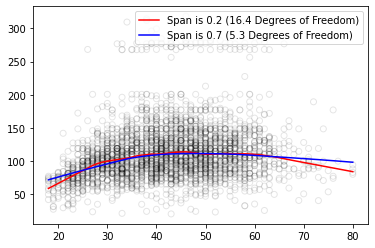

In [147]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
result1 = lowess(df.wage, df.age, frac=0.2, it=1000, delta=0.0)
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(result1[:,0], result1[:,1], color='r',label='Span is 0.2 (16.4 Degrees of Freedom)')
result2 = lowess(df.wage, df.age, frac=0.7, it=1000, delta=0.0)
plt.plot(result2[:,0], result2[:,1], color='b',label='Span is 0.7 (5.3 Degrees of Freedom)')
plt.legend()

## 7.7 Generalized Additive Models

Generalized additive models (GAMs) provide a general framework for extending a standard linear model by allowing non-linear functions of each
of the variables, while maintaining additivity. Just like linear models, GAMs can be applied with both quantitative and qualitative responses. We first
examine GAMs for a quantitative response in Section 7.7.1, and then for a
qualitative response in Section 7.7.2.

### 7.7.1 GAMs for Regression Problems

A natural way to extend the multiple linear regression model:

$$ y_i = \beta_0+\beta_1 x_{i1}+\beta_2 x_{i2}+\beta_3 x_{i3}+\ldots+\beta_p x_{ip}+\epsilon_i $$


in order to allow for non-linear relationships between each feature and the
response is to replace each linear component $β_jx_{ij}$ with a (smooth) nonlinear function $f_j(x_{ij} )$. We would then write the model as
$$y_i = \beta_0+{\sum_{i=1}^{n}f_j(x_{ij})+\epsilon_i} $$ 

$$= \beta_0+f_1 (x_{i1})+f_2 (x_{i2})+\ldots+f_p (x_{ip})+\epsilon_i \tag{7.15}
$$

This is an example of a GAM. It is called an additive model because we
calculate a separate $f_j$ for each $X_j$, and then add together all of their
contributions.

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 432x288 with 0 Axes>

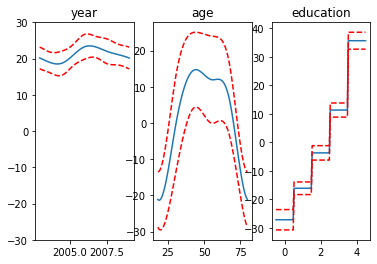

In [148]:
##figure7.11.
from pygam import LinearGAM, s, f
from pygam.datasets import wage

X, y = wage(return_X_y=True)

## model
gam = LinearGAM(s(0,n_splines=4,basis='cp') + s(1,n_splines=5,basis='cp') + f(2))
gam.gridsearch(X, y)


## plotting
plt.figure();
fig, axs = plt.subplots(1,3);

titles = ['year', 'age', 'education']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 432x288 with 0 Axes>

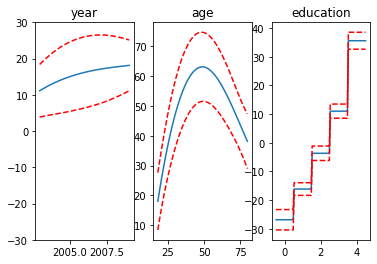

In [149]:
##figure7.12.
from pygam import LinearGAM, s, f
from pygam.datasets import wage

X, y = wage(return_X_y=True)

## model
gam = LinearGAM(s(0,n_splines=4) + s(1,n_splines=5) + f(2))
gam.gridsearch(X, y)


## plotting
plt.figure();
fig, axs = plt.subplots(1,3);

titles = ['year', 'age', 'education']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

Pros and Cons of GAMs
1:GAMs allow us to fit a non-linear $f_j$ to each $X_j$, so that we can
automatically model non-linear relationships that standard linear regression will miss. This means that we do not need to manually try
out many different transformations on each variable individually.

2: The non-linear fits can potentially make more accurate predictions
for the response Y .

3:Because the model is additive, we can still examine the effect of each
$X_j$ on Y individually while holding all of the other variables fixed.
Hence if we are interested in inference, GAMs provide a useful representation.

4：the smoothness of the function fj for the variable $X_j$ can be summarized via degrees of freedom.

5:The main limitation of GAMs is that the model is restricted to be
additive. With many variables, important interactions can be missed.
However, as with linear regression, we can manually add interaction
terms to the GAM model by including additional predictors of the
form $X_j × X_k$. In addition we can add low-dimensional interaction
functions of the form $f_(jk)(X_j , X_k)$ into the model; such terms can
be fit using two-dimensional smoothers such as local regression, or
two-dimensional splines (not covered here).

### 7.7.2 GAMs for Classification Problems

GAMs can also be used in situations where Y is qualitative. For simplicity,
here we will assume Y takes on values zero or one, and let p(X) = Pr(Y =
1|X) be the conditional probability (given the predictors) that the response
equals one. Recall the logistic regression model (4.6):
$$
log(\frac{p(x)}{1-p(x)} )=β_{0}+β_{1}x_1+β_{2}x_2+\ldots+β_{p}x_p \tag{7.17}
$$
A natural way to
extend (7.17) to allow for non-linear relationships is to use the model
$$
log(\frac{p(x)}{1-p(x)} )=β_{0}+f_{1}(x_1)+f_{2}(x_2)+\ldots+f_{p}(x_p) \tag{7.18}
$$

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 432x288 with 0 Axes>

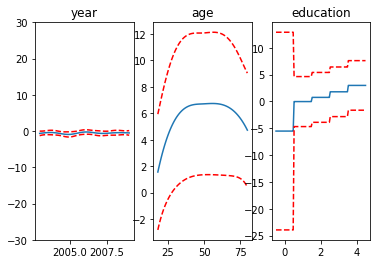

In [150]:
from pygam import LinearGAM, s, f
from pygam.datasets import wage

X, y = wage(return_X_y=True)
y = (df.wage > 250).map({False:0, True:1}).values
## model
gam =LogisticGAM(s(0) + s(1,n_splines=5) + f(2))
gam.gridsearch(X, y)


## plotting
plt.figure();
fig, axs = plt.subplots(1,3);

titles = ['year', 'age', 'education']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

<ipython-input-170-f1b92f04b5d6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x1[['education']]=x1.education.map({'2. HS Grad':2,'3. Some College':3,'4. College Grad':4, '5. Advanced Degree':5}).values
d:\python\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


ValueError: X data is out of domain for categorical feature 2. Expected data on [2.0, 5.0], but found data on [0.0, 0.0]

<Figure size 432x288 with 0 Axes>

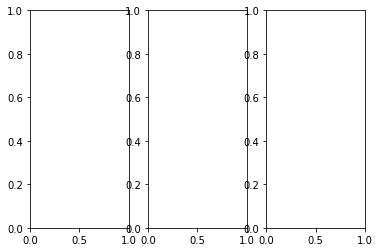

In [170]:

df=df[~df["education"].isin(["1. < HS Grad"])]
x1=df[['year','age','education','wage']]
x1[['education']]=x1.education.map({'2. HS Grad':2,'3. Some College':3,'4. College Grad':4, '5. Advanced Degree':5}).values
y=x1[['wage']]
x1=x1[['year','age','education']]
y = (y.wage > 250).map({False:0, True:1}).values
## model
gam =LogisticGAM(s(0) + s(1,n_splines=5) + f(2)).fit(x1,y)
gam.gridsearch(x1, y)

## plotting
plt.figure();
fig, axs = plt.subplots(1,3);

titles = ['year', 'age', 'education']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);